In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq, irfft
from scipy.signal import convolve
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

/home/vladislave/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


1. Реализовать сигнал с единичными выбросами. Реализовать метод для исключения выбросов в сигнале через порог стандартного отклонения. Представить очищенный сигнал.

In [2]:
def add_noise(signal, noise_level=1):
    '''
    Добавление к сигналу гауссовского шума 
    '''
    return signal + np.random.normal(0, noise_level, signal.shape)

def cos_signal(t, f, A=1):
    '''
    Функция возвращает значение косинусоидального сигнала в заданный момент времени t.
    t - время, f - список частот сигнала, A - амплитуда сигнала.
    '''
    y = 0
    for i in f:
        w = 2 * np.pi * i
        y += A * np.cos(w * t)
    return y

num = 50000  # количество отсчетов
f = [2, 10, 20, 35, 150]

# создание сигнала
t = np.linspace(0, 1, num)
y = cos_signal(t, f, A=0.2)
np.random.seed(40)
y_noised = add_noise(y, 1)

# fft
freq = rfftfreq(len(t), d=(t[1]-t[0]))
yff_signal = rfft(y_noised)

In [3]:
# Сигнал с шумом
time = np.linspace(0, 1, 1000)
signal = np.random.normal(0, 1, time.shape)

# Добавляем выбросы
num_outliers = 50
outlier_indices = np.random.choice(len(signal), num_outliers, replace=False)
signal[outlier_indices] += np.random.normal(20, 10, num_outliers)

(-10.0, 60.0)

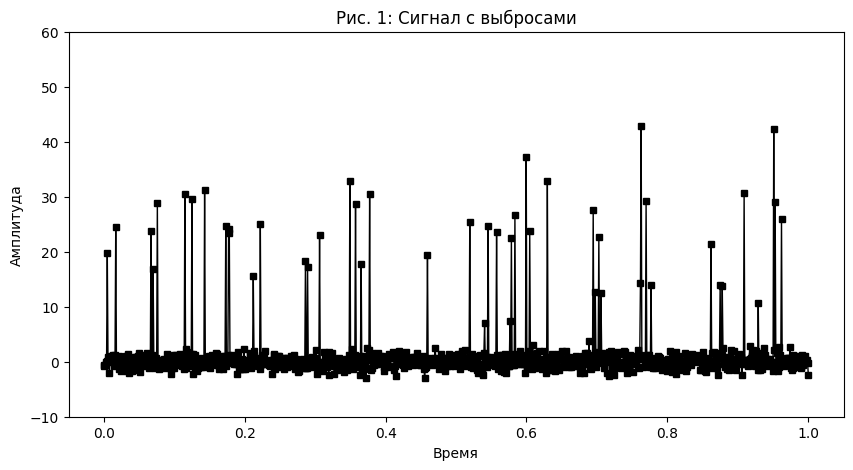

In [4]:
# Исходный сигнал с выбросами
plt.figure(figsize=(10, 5))
plt.plot(time, signal, 'k-', marker='s', markersize=4, linewidth=1)
plt.title('Рис. 1: Сигнал с выбросами')
plt.xlabel('Время')
plt.ylabel('Амплитуда')
plt.ylim(-10, 60)

In [5]:
# Обнаружение и удаление выбросов на основе стандартного отклонения
std_threshold = 3  # Порог для обнаружения выбросов
mean = np.mean(signal)
std_dev = np.std(signal)
cleaned_signal = np.where(np.abs(signal - mean) > std_threshold * std_dev, mean, signal)

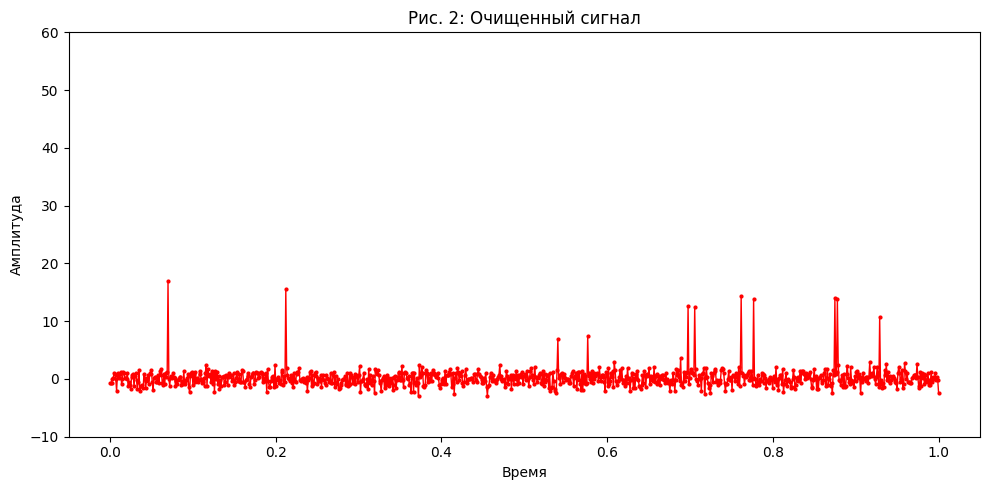

In [6]:
# Строим график очищенного сигнала
plt.figure(figsize=(10, 5))
plt.plot(time, cleaned_signal, 'r-', marker='o', markersize=2, linewidth=1)
plt.title('Рис. 2: Очищенный сигнал')
plt.xlabel('Время')
plt.ylabel('Амплитуда')
plt.ylim(-10, 60)

plt.tight_layout()
plt.show()

2. Реализовать сигнал, который содержит области с высоким уровнем шума. Это может быть сделано путем добавления случайного шума к основному сигналу в определенных интервалах времени. Напишите метод для очистки сигнала с помощью оконного скользящего среднеквадратичного отклонения (Outlier time windows via sliding RMS)

In [7]:
t = np.linspace(0, 1, 2000)
signal = np.sin(2 * np.pi * 5 * t) + np.sin(2 * np.pi * 10 * t)

# Шум в определенных интервалах времени
noise_intervals = [(500, 700), (1500, 1700)]
noisy_signal = signal.copy()
for start, end in noise_intervals:
    noisy_signal[start:end] += np.random.normal(0, 10, end - start)

In [8]:
# Функция для вычисления скользящего RMS
def sliding_rms(signal, window_size):
    return np.sqrt(np.convolve(signal**2, np.ones(window_size) / window_size, mode='same'))

In [9]:
window_size = 50
threshold = 2
rms = sliding_rms(noisy_signal, window_size)
filtered_signal = np.where(rms > threshold, 0, noisy_signal)

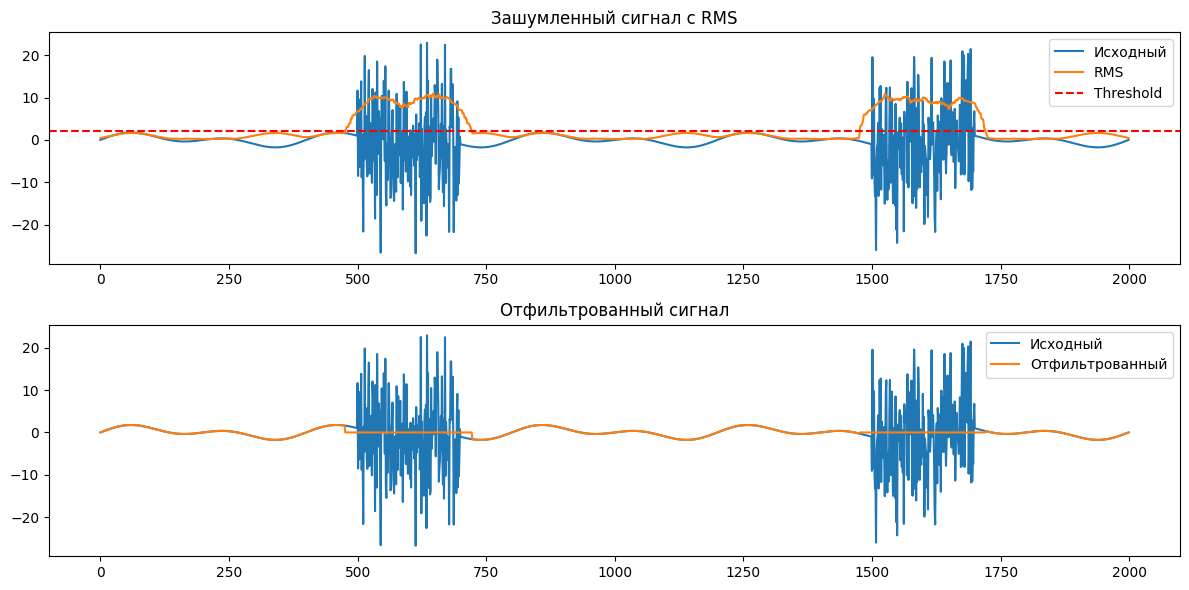

In [10]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(noisy_signal, label='Исходный')
plt.plot(rms, label='RMS')
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.title('Зашумленный сигнал с RMS')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(noisy_signal, label='Исходный')
plt.plot(filtered_signal, label='Отфильтрованный')
plt.title('Отфильтрованный сигнал')
plt.legend()

plt.tight_layout()
plt.show()

3. Метод спектральной интерполяции сигналов.
Данный метод позволяет восстановить часть сигнала, которая была потеряна или удалена.

Алгоритм реализации метода:
- определить сигнал в заданном временном промежутке, например от 0 до 10 сек.
- удалить из сигнала данные в диапазоне от 5 до 7 секунд.
- задать размер окна по временной области для которых будет определяться спектр. Размер окон
для правой и левой части должны совпадать.
- определить спектр сигнала до разрыва и после разрыва.
- осуществить усреднение спектров сигналов в правой и левой области.
- с помощью обратного преобразования Фурье восстановить утерянную часть сигнала.
- сшить границы с помощью линейной интерполяции.

In [11]:
def spectral_interpolation(signal, gap_start, gap_end, window_size):
    """
    Восстанавливает потерянную часть сигнала с помощью спектральной интерполяции.

    Параметры:
        signal (np.ndarray): Исходный сигнал с утраченной частью.
        gap_start (int): Индекс начала утраченной области.
        gap_end (int): Индекс конца утраченной области.
        window_size (int): Размер окна для определения спектра.

    Возвращает:
        np.ndarray: Восстановленный сигнал.
    """
    # Определяем окна слева и справа от утраченной области
    left_start = max(0, gap_start - window_size)
    left_end = gap_start
    right_start = gap_end
    right_end = min(len(signal), gap_end + window_size)

    left_window = signal[left_start:left_end]
    right_window = signal[right_start:right_end]

    # Вычисляем спектры окон
    left_spectrum = np.fft.fft(left_window)
    right_spectrum = np.fft.fft(right_window)

    # Усредняем спектры
    avg_spectrum = (left_spectrum + right_spectrum) / 2

    # Восстанавливаем утраченные точки с использованием усредненного спектра
    restored_length = gap_end - gap_start
    restored_freqs = np.fft.ifft(avg_spectrum).real

    # Урезаем восстановленный сигнал до необходимого размера
    restored_gap = restored_freqs[:restored_length]

    # Сшиваем границы
    restored_signal = signal.copy()
    restored_signal[gap_start:gap_end] = restored_gap
    return restored_signal

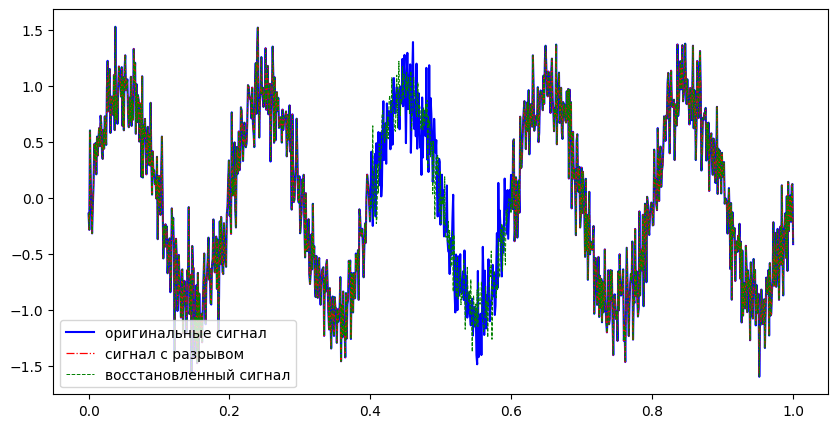

In [26]:
x = np.linspace(0, 1, 1000)
signal = np.sin(2 * np.pi * 5 * x) + 0.25 * np.random.normal(size=len(x))

gap_start, gap_end = 400, 600
signal_with_gap = signal.copy()
signal_with_gap[gap_start:gap_end] = np.nan

window_size = 200
restored_signal = spectral_interpolation(signal_with_gap, gap_start, gap_end, window_size)

plt.figure(figsize=(10, 5))
plt.plot(x, signal, color='blue', linestyle='-', label='оригинальные сигнал')
plt.plot(x, signal_with_gap, color='red', linestyle='-.', label='сигнал с разрывом', linewidth=0.9)
plt.plot(x, restored_signal, color='green', linestyle='--', label='восстановленный сигнал', linewidth=0.7)
plt.legend()

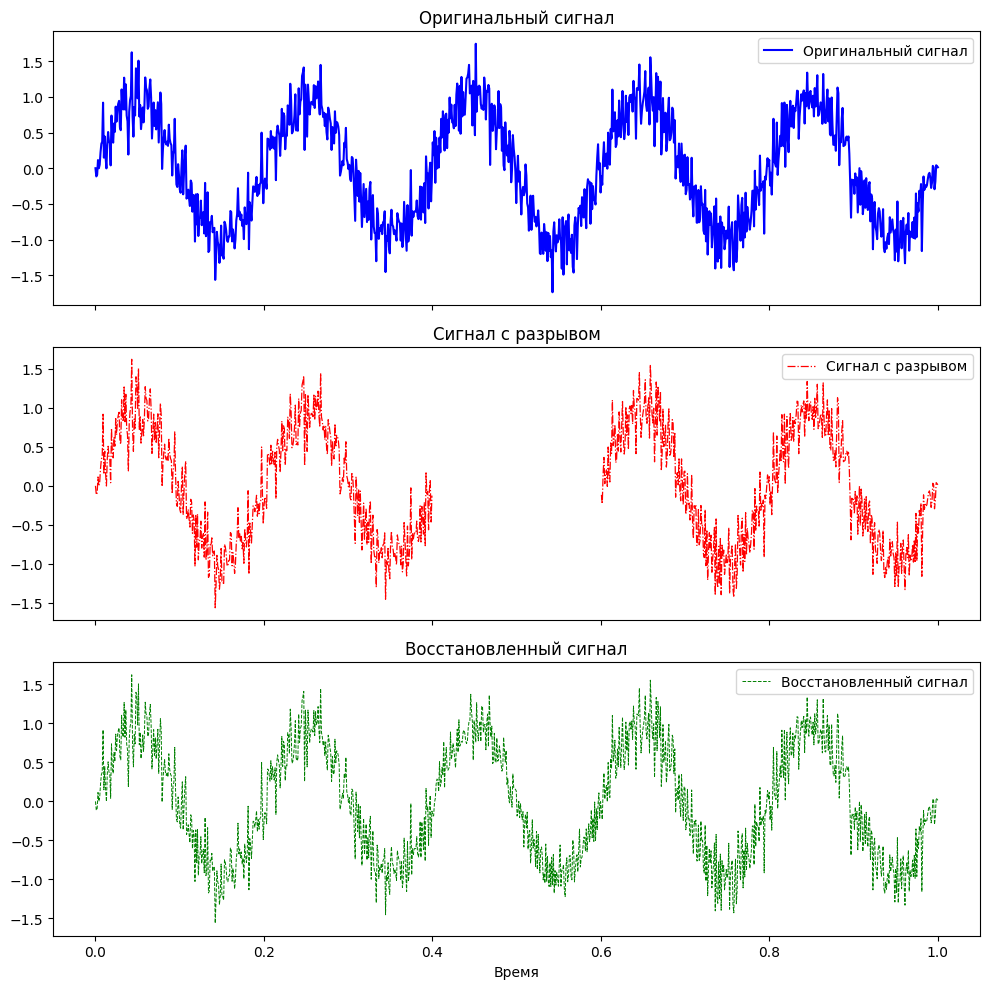

In [27]:
x = np.linspace(0, 1, 1000)
signal = np.sin(2 * np.pi * 5 * x) + 0.25 * np.random.normal(size=len(x))

gap_start, gap_end = 400, 600
signal_with_gap = signal.copy()
signal_with_gap[gap_start:gap_end] = np.nan

window_size = 200
restored_signal = spectral_interpolation(signal_with_gap, gap_start, gap_end, window_size)

# Создаем фигуру с тремя подграфиками
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# Первый график: оригинальный сигнал
axs[0].plot(x, signal, color='blue', linestyle='-', label='Оригинальный сигнал')
axs[0].set_title('Оригинальный сигнал')
axs[0].legend()

# Второй график: сигнал с разрывом
axs[1].plot(x, signal_with_gap, color='red', linestyle='-.', label='Сигнал с разрывом', linewidth=0.9)
axs[1].set_title('Сигнал с разрывом')
axs[1].legend()

# Третий график: восстановленный сигнал
axs[2].plot(x, restored_signal, color='green', linestyle='--', label='Восстановленный сигнал', linewidth=0.7)
axs[2].set_title('Восстановленный сигнал')
axs[2].legend()

# Настройка общего оси X
axs[2].set_xlabel('Время')

# Отображение графика
plt.tight_layout()
plt.show()

4. Алгоритм понижения/повышения дискретности сигнала в N раз.
Понижение дискретности сигнала можно осуществить двумя методами:\
(а) уменьшением числа точек в сигнале в N раз (неправильный). Замечание: для увеличения
дискретности сигнала данным способом можно воспользоваться и он будет правильным.\
(б) уменьшением дискретности сигнала в N раз (правильный) с помощью определения новой частоты
Найквиста, которая будет соответствовать новой дискретности сигнала.
Понижение дискретности сигнала осуществляется в три этапа:
- pick new sampling rate
- low-pass filter at new Nyquist
- downsample

В качестве исходного сигнала можно выбрать сигнал косинуса с двумя частотами, например, 50 и 100 Гц.

In [17]:
num3 = 400  # количество отсчетов

# создание сигнала
t3 = np.linspace(0, 0.1, num3)
y3 = cos_signal(t3, [50, 100], A=0.2)

# fft
freq3 = rfftfreq(len(t3), d=(t3[1]-t3[0]))
yff_signal3 = rfft(y3)

In [18]:
def downsample(y, original_sampling_rate, new_sampling_rate):
    """Понижает дискретность сигнала."""
    N = len(y)
    new_Nyquist = new_sampling_rate / 2

    # Применение фильтра нижних частот
    spectrum = np.fft.rfft(y)
    frequencies = np.fft.rfftfreq(N, d=1/original_sampling_rate)
    mask = frequencies <= new_Nyquist
    filtered_signal = np.fft.irfft(spectrum * mask, N)

    # Понижение дискретности
    factor = original_sampling_rate / new_sampling_rate
    new_length = int(N / factor)
    x_old = np.arange(N)
    x_new = np.linspace(0, N - 1, new_length)
    y_down = np.interp(x_new, x_old, filtered_signal)

    return y_down

def upsample(y, original_sampling_rate, new_sampling_rate):
    """Повышает дискретность сигнала с использованием линейной интерполяции."""
    N = len(y)
    factor = new_sampling_rate / original_sampling_rate
    new_length = int(N * factor)
    x_old = np.arange(N)
    x_new = np.linspace(0, N - 1, new_length)
    return np.interp(x_new, x_old, y)

# Понижение дискретности сигнала
original_sampling_rate = 1 / (t3[1] - t3[0])
y3_down = downsample(y3, original_sampling_rate, original_sampling_rate / 2)
t3_down = np.linspace(0, 0.1, len(y3_down), endpoint=False)

# Повышение дискретности сигнала
y3_up = upsample(y3, original_sampling_rate, original_sampling_rate * 2)
t3_up = np.linspace(0, 0.1, len(y3_up), endpoint=False)


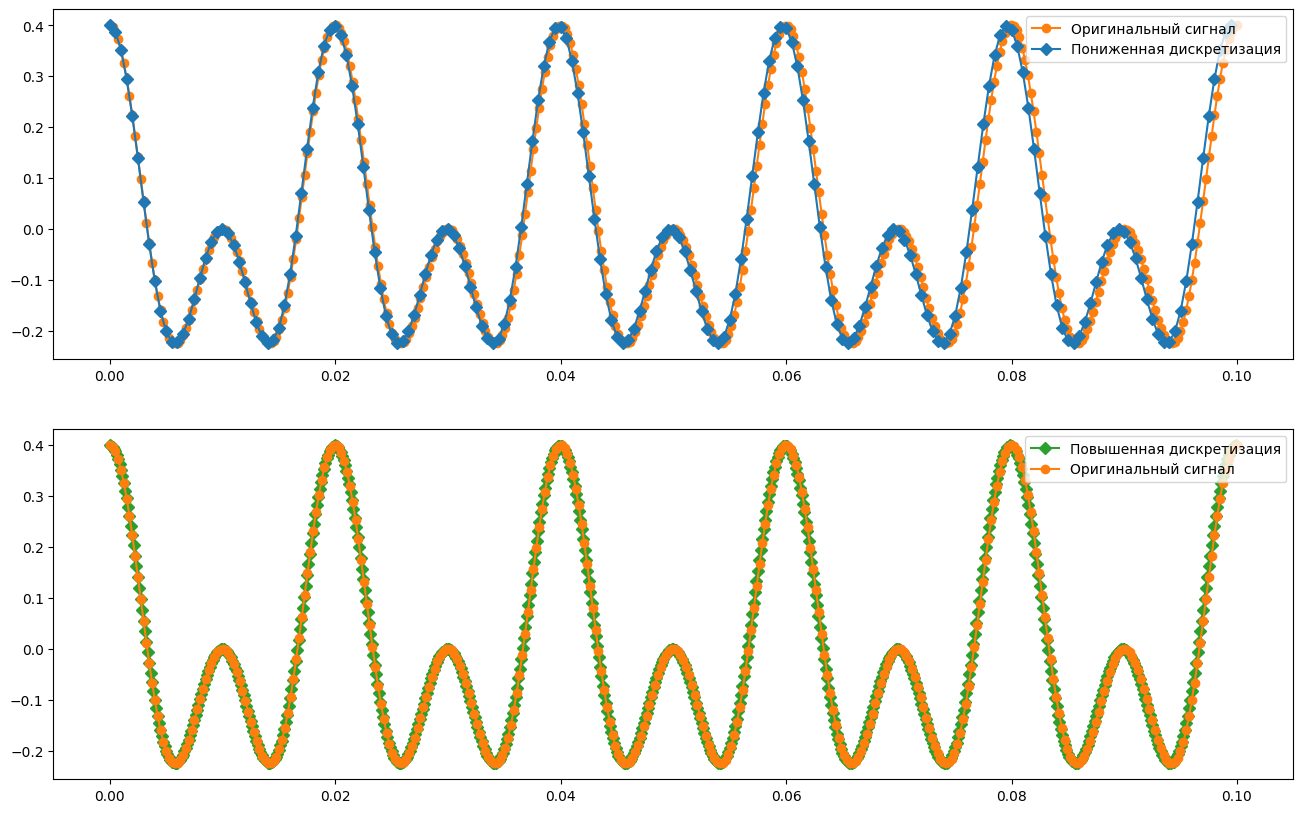

In [19]:
# Вывод результатов
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
plt.plot(t3, y3, color='C1', marker='o', label='Оригинальный сигнал')
plt.plot(t3_down, y3_down, color='C0', marker='D', label='Пониженная дискретизация')
plt.legend(loc='upper right')

plt.subplot(2, 1, 2)
plt.plot(t3_up, y3_up, color='C2', marker='D', label='Повышенная дискретизация')
plt.plot(t3, y3, color='C1', marker='o', label='Оригинальный сигнал')
plt.legend(loc='upper right')

plt.show()

5. В результате записи сигналов с 3-х различных датчиков были записаны данные с различной частотой
дискретизации. Привести все сигналы к единой частоте дискретизации. В качестве сигналов можно выбрать три косинуса с различной частотой дискретизации,
например 10, 35 и 80 Гц.

In [20]:
# Создание временного ряда для каждого сигнала
rates = [80, 35, 10]
times = [np.linspace(0, 0.1, int(freq / 0.1), False) for freq in rates]
# Создание сигналов с различной частотой дискретизации
signals = [cos_signal(time, [50]) for time in times]

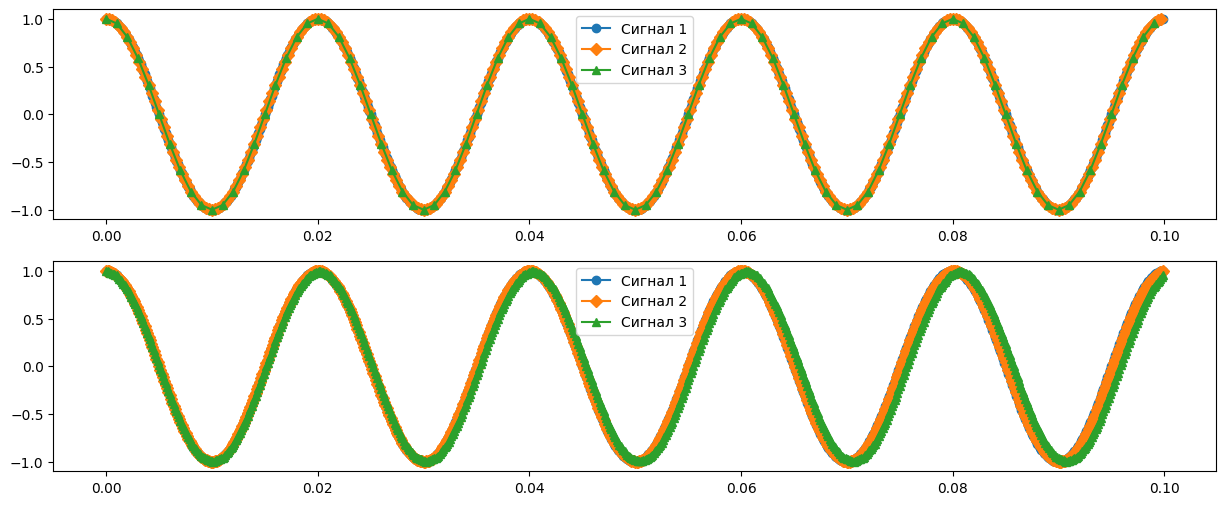

In [21]:
def resample_to_max_rate(signals, rates):
    """
    Функция принимает список сигналов и их частоты дискретизации,
    и приводит все сигналы к наибольшей частоте дискретизации.
    """
    max_rate = max(rates)
    resampled_signals = []

    for signal, rate in zip(signals, rates):
        if rate < max_rate:
            resampled_signals.append(upsample(signal, rate, max_rate))
        else:
            resampled_signals.append(signal)

    return resampled_signals

# Приведение всех сигналов к единой частоте дискретизации
resampled_signals = resample_to_max_rate(signals, rates)

# Визуализация результатов
plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
markers=['o', 'D', '^']
for i, sig in enumerate(signals):
    plt.plot(times[i], sig, marker=markers[i], label=f'Сигнал {i+1}')
plt.legend()

plt.subplot(2, 1, 2)
for i, sig in enumerate(resampled_signals):
    plt.plot(times[0], sig, marker=markers[i], label=f'Сигнал {i+1}')
plt.legend()
plt.show()


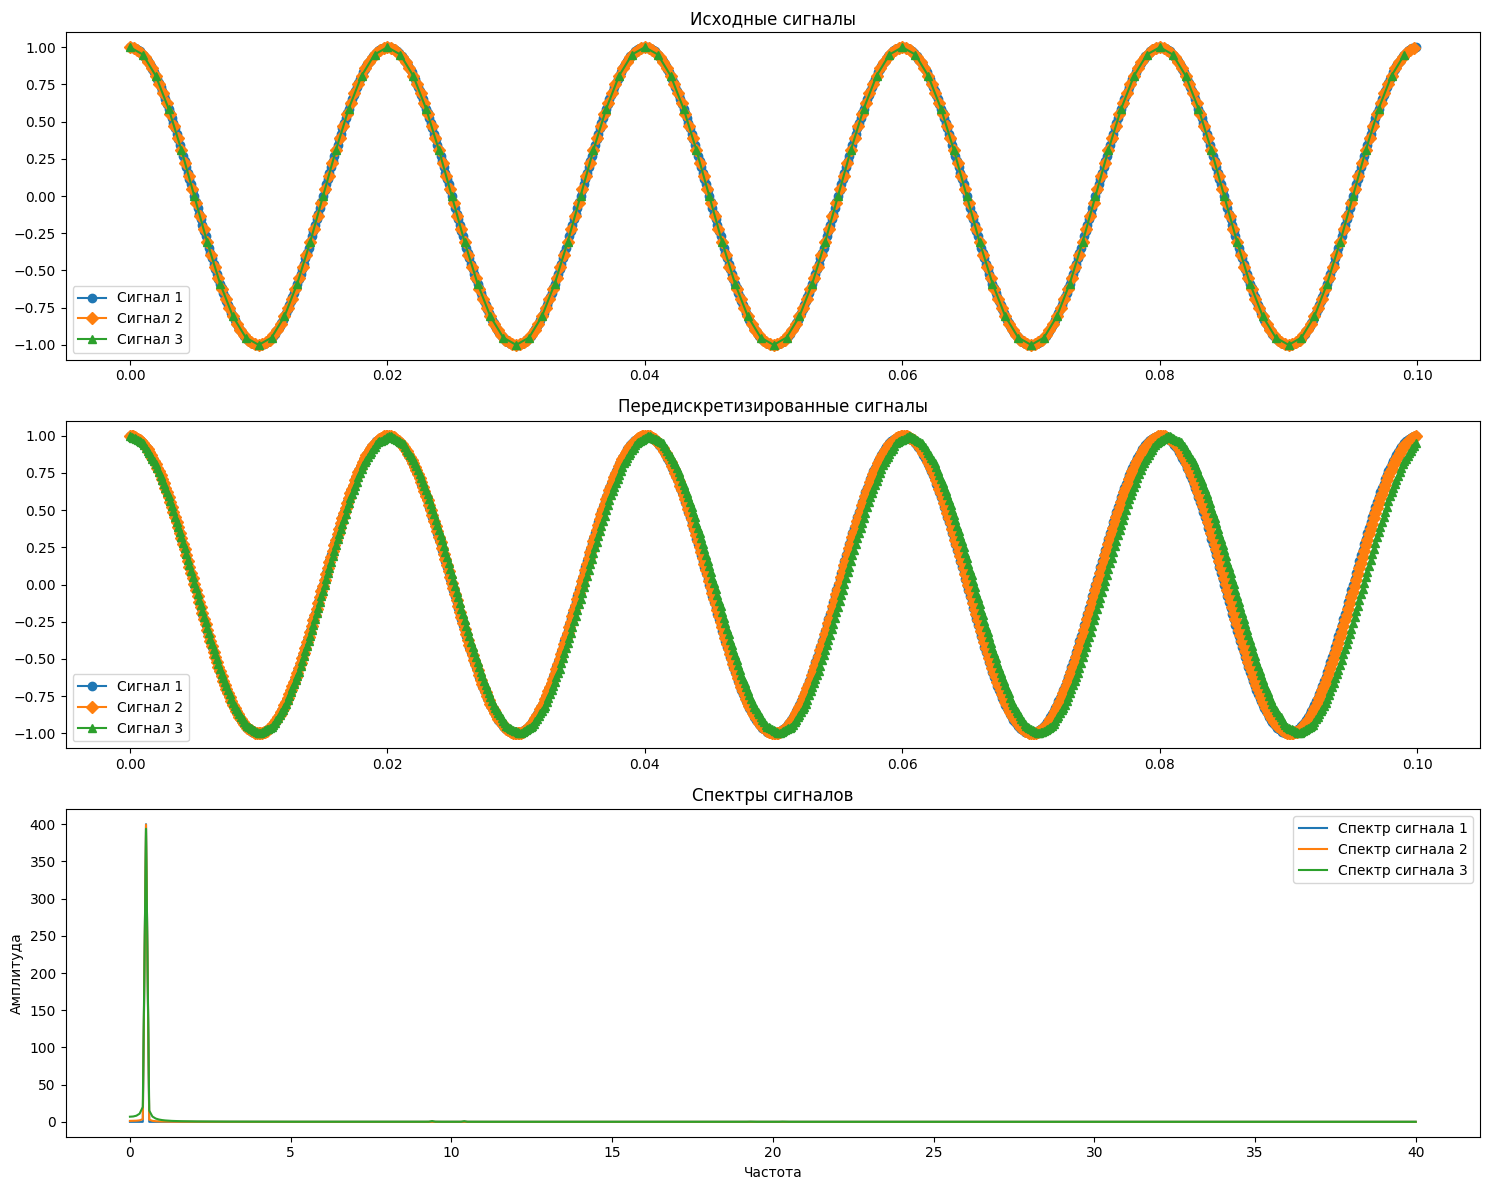

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq

def add_noise(signal, noise_level=1):
    '''
    Добавление к сигналу гауссовского шума 
    '''
    return signal + np.random.normal(0, noise_level, signal.shape)

def cos_signal(t, f, A=1):
    '''
    Функция возвращает значение косинусоидального сигнала в заданный момент времени t.
    t - время, f - список частот сигнала, A - амплитуда сигнала.
    '''
    y = 0
    for i in f:
        w = 2 * np.pi * i
        y += A * np.cos(w * t)
    return y

def upsample(signal, original_rate, target_rate):
    """
    Увеличение частоты дискретизации сигнала.
    """
    factor = target_rate / original_rate
    return np.interp(np.linspace(0, 1, int(len(signal) * factor)), np.linspace(0, 1, len(signal)), signal)

num = 50000  # количество отсчетов
f = [2, 10, 20, 35, 150]

# создание сигнала
t = np.linspace(0, 1, num)
y = cos_signal(t, f, A=0.2)
np.random.seed(40)
y_noised = add_noise(y, 1)

# fft
freq = rfftfreq(len(t), d=(t[1]-t[0]))
yff_signal = rfft(y_noised)

# Создание временного ряда для каждого сигнала
rates = [80, 35, 10]
times = [np.linspace(0, 0.1, int(freq / 0.1), False) for freq in rates]
# Создание сигналов с различной частотой дискретизации
signals = [cos_signal(time, [50]) for time in times]

def resample_to_max_rate(signals, rates):
    """
    Функция принимает список сигналов и их частоты дискретизации,
    и приводит все сигналы к наибольшей частоте дискретизации.
    """
    max_rate = max(rates)
    resampled_signals = []

    for signal, rate in zip(signals, rates):
        if rate < max_rate:
            resampled_signals.append(upsample(signal, rate, max_rate))
        else:
            resampled_signals.append(signal)

    return resampled_signals

# Приведение всех сигналов к единой частоте дискретизации
resampled_signals = resample_to_max_rate(signals, rates)

# Визуализация результатов
plt.figure(figsize=(15, 12))

# Исходные сигналы
plt.subplot(3, 1, 1)
markers=['o', 'D', '^']
for i, sig in enumerate(signals):
    plt.plot(times[i], sig, marker=markers[i], label=f'Сигнал {i+1}')
plt.legend()
plt.title('Исходные сигналы')

# Передискретизированные сигналы
plt.subplot(3, 1, 2)
for i, sig in enumerate(resampled_signals):
    plt.plot(times[0], sig, marker=markers[i], label=f'Сигнал {i+1}')
plt.legend()
plt.title('Передискретизированные сигналы')

# Спектры сигналов
plt.subplot(3, 1, 3)
for i, sig in enumerate(resampled_signals):
    freqs = rfftfreq(len(sig), d=1/max(rates))
    spectrum = np.abs(rfft(sig))
    plt.plot(freqs, spectrum, label=f'Спектр сигнала {i+1}')
plt.legend()
plt.title('Спектры сигналов')
plt.xlabel('Частота')
plt.ylabel('Амплитуда')

plt.tight_layout()
plt.show()